In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
#intializing spark dataframe
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
import pandas as pd
from pyspark.sql.functions import avg, count, desc, asc, explode, split, col, regexp_extract, lower



# Initialize a Spark session
spark = SparkSession.builder \
    .appName("MovieRatingsAnalysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.extraClassPath", "/Users/bharathpalanisamy/Downloads/postgresql-42.7.4.jar") \
    .config("spark.jars", "/Users/bharathpalanisamy/Downloads/postgresql-42.7.4.jar") \
    .getOrCreate()

24/08/30 09:02:49 WARN Utils: Your hostname, Bharaths-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.10.13 instead (on interface en0)
24/08/30 09:02:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/08/30 09:02:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
from sqlalchemy import create_engine

#Connecting to the Postgres database
DATABASE_TYPE = 'postgresql'
DBAPI = 'psycopg2'
ENDPOINT = 'localhost'
USER = 'postgres'
PASSWORD = 'Bharath12!'
PORT = 5432
DATABASE = 'NewDatabase'

engine = create_engine(f'{DATABASE_TYPE}+{DBAPI}://{USER}:{PASSWORD}@{ENDPOINT}:{PORT}/{DATABASE}')
conn = engine.connect()

In [4]:
#Loading the data for movies and ratings into a spark dataframe
ratings_df = spark.read.csv('downloads/ml-latest-small/ratings.csv', header=True, inferSchema=True)
movies_df = spark.read.csv('downloads/ml-latest-small/movies.csv', header = True, inferSchema=True)

In [5]:
#Jdbc url for the connection between pyspark and postgresql
URL = f"jdbc:postgresql://localhost/NewDatabase"

# Merging ratings and movies DataFrames
merged_df = ratings_df.join(movies_df, on='movieId')

In [6]:
from pyspark.sql.functions import avg, count, desc, asc, explode, split, col, regexp_extract, lower, broadcast
# Data Cleansing
# Remove duplicates
ratings_df = ratings_df.dropDuplicates()
movies_df = movies_df.dropDuplicates()

# Handle missing values
# For ratings_df: Replace null ratings with a default value (e.g., 0 or the average rating)
ratings_df = ratings_df.fillna({'rating': 0})

# For movies_df: Replace missing values in title or genres with a default value or handle accordingly
movies_df = movies_df.fillna({'title': 'Unknown', 'genres': 'Unknown'})

# Normalize data formats
# Ensure genres are in a consistent format (e.g., lowercase)
movies_df = movies_df.withColumn('genres', lower(col('genres')))

In [7]:
# 1. Calculate average ratings for each movie
average_ratings_df = merged_df.groupBy('title').agg(avg('rating').alias('average_rating'))

# Define JDBC URL
URL = f"jdbc:postgresql://{ENDPOINT}:{PORT}/{DATABASE}"

# Write average ratings to PostgreSQL
average_ratings_df.write \
    .format("jdbc") \
    .option("url", URL) \
    .option("dbtable", "average_movie_ratings") \
    .option("user", USER) \
    .option("password", PASSWORD) \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("Average movie ratings have been saved to the 'average_movie_ratings' table in PostgreSQL.")

Average movie ratings have been saved to the 'average_movie_ratings' table in PostgreSQL.


#Joined ratings on to movies to get the average rating for each movie
merged_df = ratings_df.join(movies_df, on='movieId')

average_ratings_df = merged_df.groupBy('title') \
    .agg(avg('rating').alias('average_rating'))

average_ratings_df.write \
    .format("jdbc") \
    .option("url", URL) \
    .option("dbtable", "movies") \
    .option("user", USER) \
    .option("password", PASSWORD) \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("Average movie ratings have been saved to the 'average_movie_ratings' table in PostgreSQL.")

In [8]:
# 2. Top 10 Movies with the Most Ratings and total ratings
ratings_count_df = merged_df.groupBy('title') \
    .agg(count('rating').alias('ratings_count')) \
    .orderBy(desc('ratings_count'))

top_10_movies_df = ratings_count_df.limit(20)

top_10_movies_df.write \
    .format("jdbc") \
    .option("url", URL) \
    .option("dbtable", "top_10_highest_rated_movies") \
    .option("user", USER) \
    .option("password", PASSWORD) \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()


print("Top 10 movie ratings have been saved to the 'top_10_highest_rated_movies' table in PostgreSQL.")

Top 10 movie ratings have been saved to the 'top_10_highest_rated_movies' table in PostgreSQL.


In [9]:
#3. Average rating by genre
#split each genre into rows
genres_df = movies_df.select('movieId', explode(split(col('genres'), '\\|')).alias('genre'))

#Merging ratings_df with genres_df
merged_genres_df = ratings_df.join(genres_df, on='movieId')

#calculating the average rating
avg_rating_by_genre_df = merged_genres_df.groupBy('genre') \
    .agg(count('rating').alias('average_rating')) \
    .orderBy(desc('average_rating'))

# Write the average ratings by genre to PostgreSQL
avg_rating_by_genre_df.write \
    .format("jdbc") \
    .option("url", URL) \
    .option("dbtable", "average_rating_by_genre") \
    .option("user", USER) \
    .option("password", PASSWORD) \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

#Printing that you have successfully stored in postgres DB
print("Average ratings by genre have been saved to the 'average_rating_by_genre' table in PostgreSQL.")

Average ratings by genre have been saved to the 'average_rating_by_genre' table in PostgreSQL.


In [10]:
# 4.) Shows the year and average rating for movies for that year
# Extract year from movie titles
movies_with_year_df = movies_df.withColumn('year', regexp_extract(col('title'), r'\((\d{4})\)', 1))

# Merge with ratings data
ratings_with_year_df = ratings_df.join(movies_with_year_df.select('movieId', 'year'), on='movieId')

# Filter out records without a valid year
ratings_with_year_df = ratings_with_year_df.filter(col('year') != '')

# Convert year to integer type
ratings_with_year_df = ratings_with_year_df.withColumn('year', col('year').cast('integer'))

# Calculate average rating per year
average_rating_by_year_df = ratings_with_year_df.groupBy('year') \
    .agg(avg('rating').alias('average_rating')) \
    .orderBy('year')

# Write the average ratings by year to PostgreSQL
average_rating_by_year_df.write \
    .format("jdbc") \
    .option("url", URL) \
    .option("dbtable", "average_rating_by_year") \
    .option("user", USER) \
    .option("password", PASSWORD) \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .option("partitionBy", "year") \
    .save()

print("Average ratings by year have been saved to the 'average_rating_by_year' table in PostgreSQL.")

Average ratings by year have been saved to the 'average_rating_by_year' table in PostgreSQL.


In [11]:
# 1. Extract year from movie titles
new_movies_with_year_df = movies_df.withColumn('year', regexp_extract(col('title'), r'\((\d{4})\)', 1))

# 2. Merge with ratings data (already done)
new_ratings_with_year_df = ratings_df.join(new_movies_with_year_df.select('movieId', 'title', 'year'), on='movieId')

# 3. Calculate average rating for each movie and include the year
average_rating_with_year_df = new_ratings_with_year_df.groupBy('title', 'year') \
    .agg(avg('rating').alias('average_rating')) \
    .orderBy(desc('average_rating'))

# 4. Select the top N movies based on average rating
# 5. Write the top N movies with their year to PostgreSQL
average_rating_with_year_df.write \
    .format("jdbc") \
    .option("url", URL) \
    .option("dbtable", "top_n_highest_rated_movies_with_year") \
    .option("user", USER) \
    .option("password", PASSWORD) \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("Top N highest-rated movies with their year have been saved to the 'top_n_highest_rated_movies_with_year' table in PostgreSQL.")


Top N highest-rated movies with their year have been saved to the 'top_n_highest_rated_movies_with_year' table in PostgreSQL.


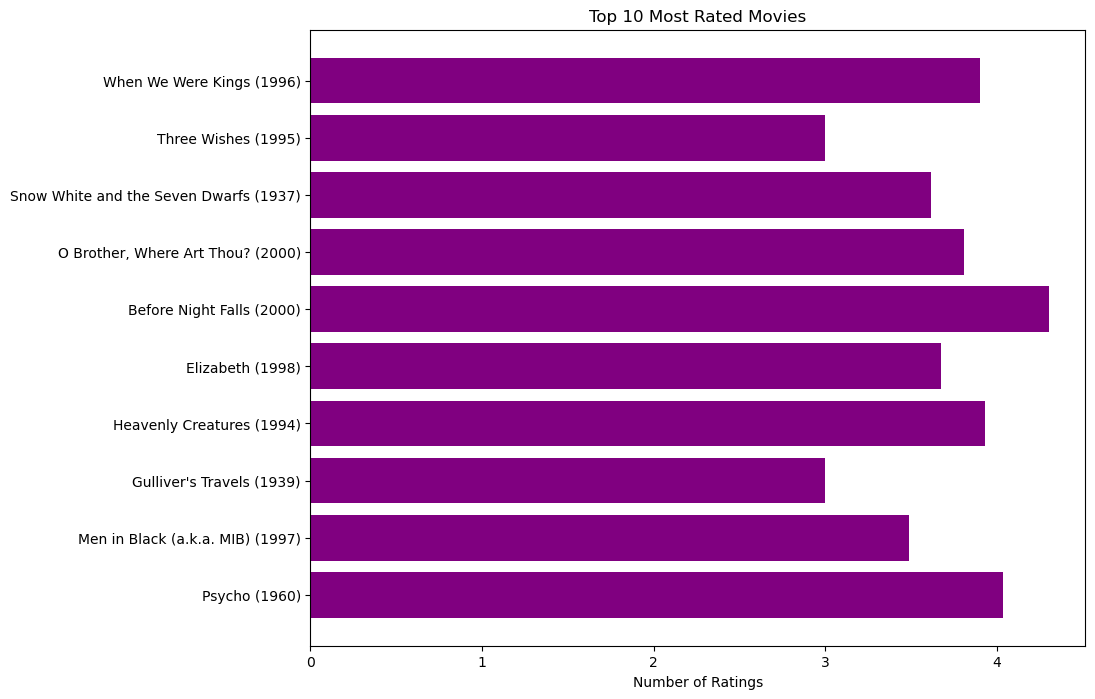

In [12]:
# Ensure DataFrame contains only the top 10 rows (if SQL query is not limiting correctly)
import matplotlib.pyplot as plt

average_movie_rating_query = """
SELECT * FROM average_movie_ratings
LIMIT 10;
"""
average_movie_rating_query_to_graph = pd.read_sql_query(average_movie_rating_query, conn)

average_movie_rating_query_to_graph = average_movie_rating_query_to_graph.head(10)


# Plotting Top 10 Most Rated Movies
plt.figure(figsize=(10, 8))
plt.barh(average_movie_rating_query_to_graph['title'], average_movie_rating_query_to_graph['average_rating'], color='purple')
plt.xlabel('Number of Ratings')
plt.title('Top 10 Most Rated Movies') # Invert y-axis to show the highest count on top
plt.show()

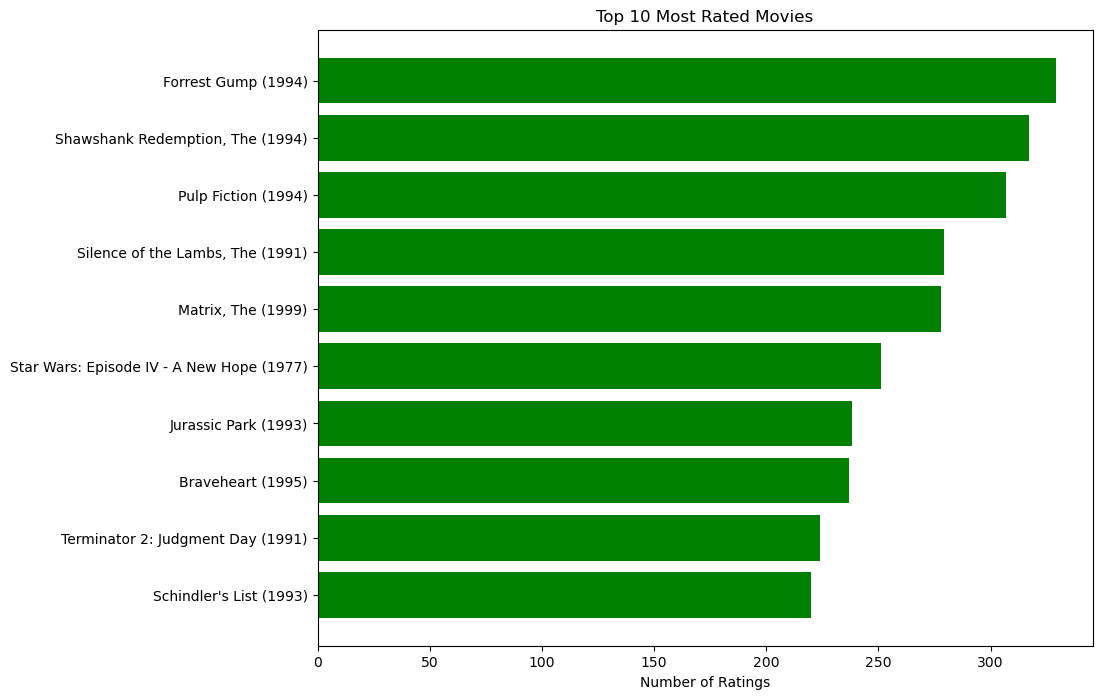

In [13]:
#graph for top 10 highest rated movies based on total ratings people rated
top_10_highest_rated_movies_based_on_total_ratings_df = """
SELECT * FROM top_10_highest_rated_movies
LIMIT 10;
"""

top_10_highest_rated_movies_total_ratings = pd.read_sql_query(top_10_highest_rated_movies_based_on_total_ratings_df, conn)

top_10_highest_rated_movies_total_ratings = top_10_highest_rated_movies_total_ratings.head(10)

# Plotting Top 10 Most Rated Movies
plt.figure(figsize=(10, 8))
plt.barh(top_10_highest_rated_movies_total_ratings['title'], top_10_highest_rated_movies_total_ratings['ratings_count'], color='green')
plt.xlabel('Number of Ratings')
plt.title('Top 10 Most Rated Movies') # Invert y-axis to show the highest count on top
plt.gca().invert_yaxis()
plt.show()

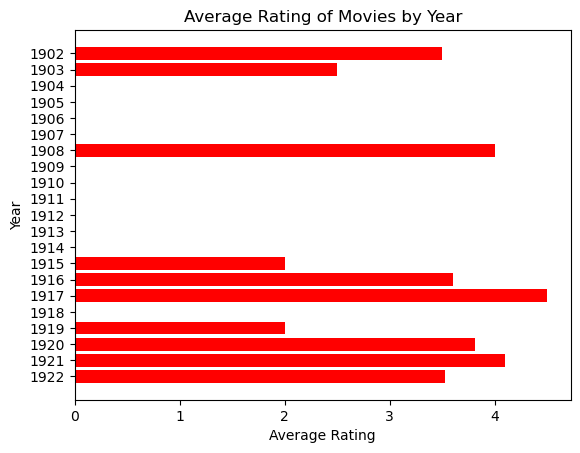

In [14]:
import numpy as np

# Query for avg rating by genre
avg_rating_of_movies_by_year_query = """
SELECT * FROM average_rating_by_year
LIMIT 10;
"""


#Calling the query and establishing the connection to get the data
avg_rating_of_movies_by_year = pd.read_sql_query(avg_rating_of_movies_by_year_query, conn)

# Create a range of years from the minimum to the maximum in your data
year_ticks = np.arange(avg_rating_of_movies_by_year['year'].min(), avg_rating_of_movies_by_year['year'].max() + 1, 1)

# Plotting Top 10 Most Rated Movies
plt.barh(avg_rating_of_movies_by_year['year'], avg_rating_of_movies_by_year['average_rating'], color='red')
plt.xlabel('Average Rating')
plt.ylabel('Year')
plt.title('Average Rating of Movies by Year')

# Set y-axis ticks to show every year
plt.yticks(year_ticks)

# Invert y-axis to show the highest count on top
plt.gca().invert_yaxis()

plt.show()


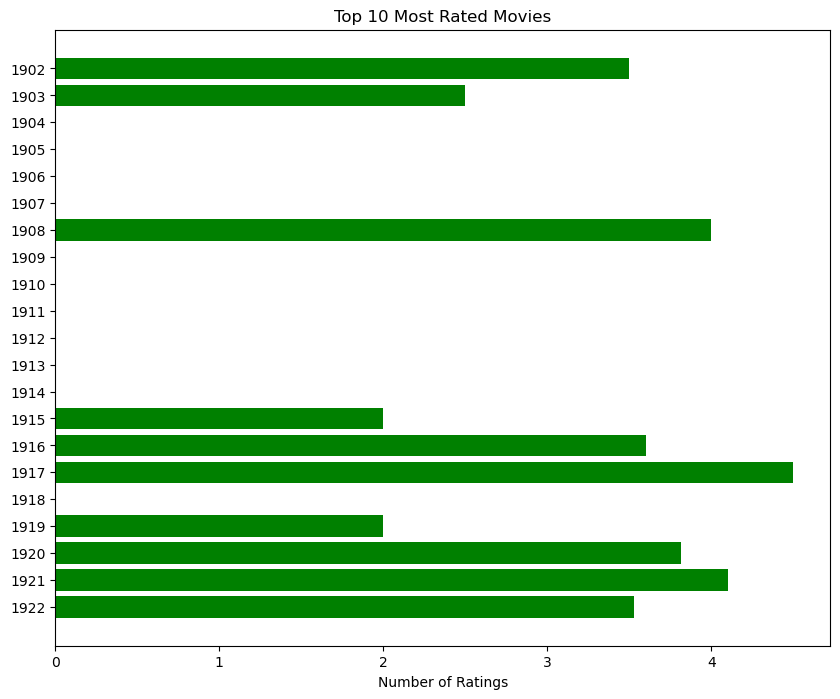

In [15]:
#Average rating of movies based on the year released
average_rating_per_year_df = """
SELECT * FROM average_rating_by_year
LIMIT 10;
"""

average_rating_per_year = pd.read_sql_query(average_rating_per_year_df, conn)

year_ticks = np.arange(average_rating_per_year['year'].min(), average_rating_per_year['year'].max() + 1, 1)

# Plotting Top 10 Most Rated Movies
plt.figure(figsize=(10, 8))
plt.barh(average_rating_per_year['year'], average_rating_per_year['average_rating'], color='green')
plt.xlabel('Number of Ratings')
plt.title('Top 10 Most Rated Movies')
plt.yticks(year_ticks)
# Invert y-axis to show the highest count on top
plt.gca().invert_yaxis()
plt.show()

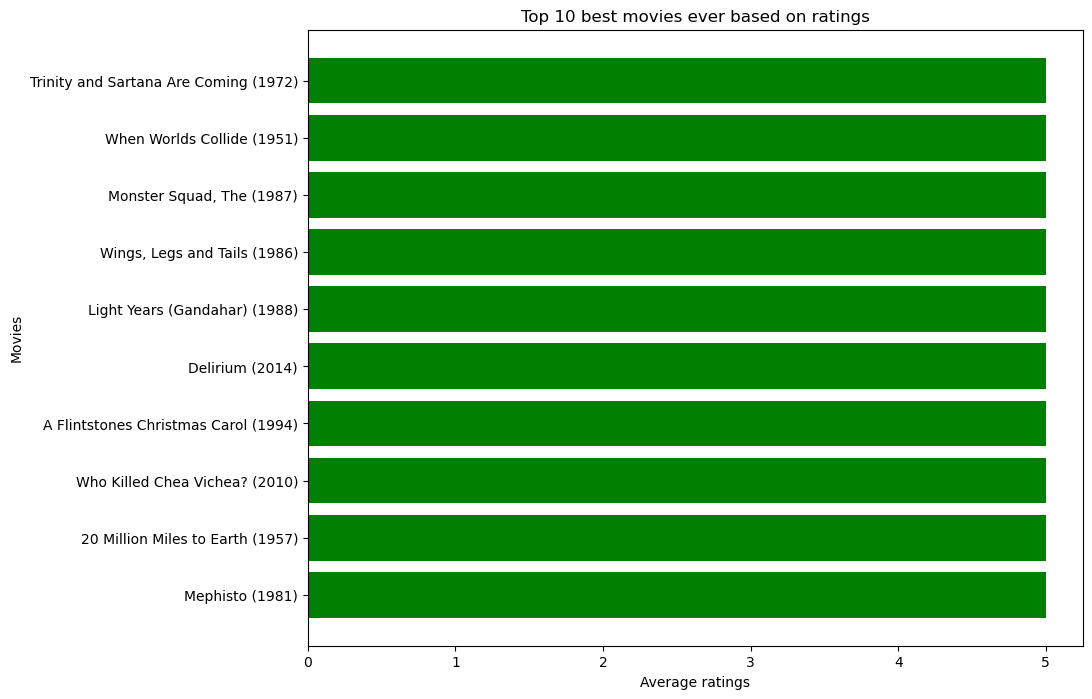

In [16]:
#graph for top 10 highest rated movies based on total ratings people rated
avgRatingForMovieDf = """
SELECT * FROM top_n_highest_rated_movies_with_year
LIMIT 10;
"""

avgRatingAlongWithYear = pd.read_sql_query(avgRatingForMovieDf, conn)

avgRatingAlongWithYear = avgRatingAlongWithYear.head(10)

# Plotting Top 10 Most Rated Movies
plt.figure(figsize=(10, 8))
plt.barh(avgRatingAlongWithYear['title'], avgRatingAlongWithYear['average_rating'], color='green')
plt.xlabel('Average ratings')
plt.ylabel('Movies')
plt.title('Top 10 best movies ever based on ratings') # Invert y-axis to show the highest count on top
plt.gca().invert_yaxis()
plt.show()